## Linear Regression

Linear Regression is one of the simplest, oldest and more used
methods of data analysis and in many cases is the starting point
when we try to derive a model by fitting a straight line to data.

In its simplest version we have one independent and one depended
variables and we are trying to a find a **linear** relationship
between them that will allow us to make predictions based on unseen
before values.


In [218]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [219]:
def make_dummy_data(func, x1=0, x2=100, count=10, mu=0, sigma=65):
    """Creates testing data to use for simple Linear Regression.
    
    :param callable func: A linear function that maps the x value 
    to a y; resembles the y = ax + b functionality.
    
    :param float x1: The min x for the data set to return.
    :param float y1: The max y for the data set to return.
    :param int count: The number of the points to return.
    :param float mu: The mean value of the residual distribution.
    :param float sigma: The sigma value of the residual distribution.
    
    :returns: A tuple consisting of the x and y values that correspond
    to the passed in parameters.
    
    :rtype: tuple[list, list]
    """
    x_values = np.random.uniform(low=x1, high=x2, size=(count,))
    noise = np.random.normal(mu, sigma, count)
    y_values = []
    for index, x in enumerate(x_values):
        y = func(x)
        noisy_value = y + noise[index]
        y_values.append(noisy_value)
    return x_values, y_values

### Developing intuition

Using the function to make dummy data, we can simulate a random population
of points expressed as tuples $(x,y)$ that can mimic some data that we have
collected for a specific experiment.

In our case, we now in advance the function that is combining the dependent with
the independent variable which can be expressed in a linear format as follows:

$\Large y = a \cdot x + b$

Note that the dummy point generator is adding some random noise (normally distributed)
to make our case study more realistic.

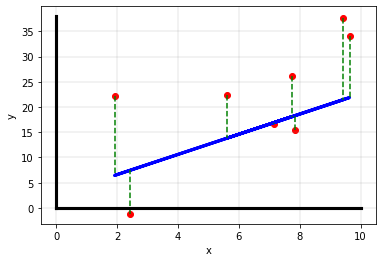

In [220]:
func = lambda x: 5 + 2.8 * x
x_values, y_values = make_dummy_data(func=func, x1=0, x2=10 , sigma=8, count=8)

max_x = int(max(x_values)) + 2
max_y = int(max(y_values)) + 2

plt.scatter(x_values, y_values, color="red")

# Pick a random line.
func_1 = lambda x: 2.6 + 2.0 * x
y_1 = [func_1(x) for x in x_values ]
plt.plot(x_values, y_1, color='blue', linewidth=3.1)

# Print the distances from the points
delta_y = []
for index in range(len(x_values)):
    x = x_values[index]
    plt.plot([x,  x] , [y_values[index], func_1(x)] , color='green', linestyle='dashed',)
    delta_y.append((x, y_values[index] - func_1(x)))
    
plt.plot([x for x in range(0, max_x)], [0 for x in range(0, max_x)], color="black", linewidth = 3.1)
plt.plot([0 for x in range(0, max_y)], [y for y in range(0, max_y)], color="black", linewidth = 3.1)

plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("x")
plt.ylabel("y")

delta_y.sort(key= lambda p: p[0])
df = pd.DataFrame(delta_y, columns = ['x', 'ΔY'])
df['ΔY^2'] = df.apply(lambda row: row["ΔY"]**2, axis=1)
squares_sum =  df['ΔY'].sum()     

In [221]:
df

,x,ΔY,ΔY^2
0,1.917012,15.661482,245.282011
1,2.434979,-8.661640,75.024004
2,5.621255,8.502621,72.294568
3,7.148332,-0.303682,0.092223
4,7.746666,8.107833,65.736951
5,7.835514,-2.733731,7.473284
6,9.432917,16.140185,260.505582
7,9.638163,12.187070,148.524674


The "blue" line that we have ploted above is a randomnly selected one having 
arbitrary values for its **slope** ($a$) and **intercept** ($b$)

### How to find the best values for a and b

From the 3-d graphical represenation that follows we can see how the observed error
varies based on the values of $a$ and $b$.

Our objective is to find out the values of both $a$ and $b$ that minimize the error.
It is easy to realize that since the error function is monotonous, we need to find
the values that make the derivates of them equal to zero, or expresssed more 
formally the following:

$\Large \frac {\partial C} {\partial a} = 0$

$\Large \frac {\partial C} {\partial b} = 0$


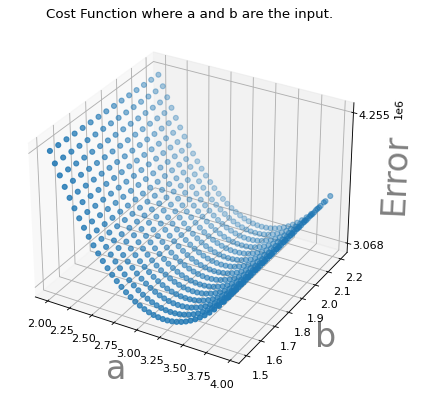

In [222]:
func = lambda x:3.2*x  + 2.2
x_values, y_values = make_dummy_data(func=func,  x1=0, x2=50, mu=0, sigma=55,  count=1000)
zis, yis, xis = [], [], []

step = .05
for a in np.arange(2, 4, step):
    for b in np.arange(1.5, 2.2, step):
        xis.append(a)
        yis.append(b)
        s = 0
        for x, y in zip(x_values, y_values):
            s += (a * x + b - y) **2
        zis.append( s) 
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection ='3d')
ax.scatter(xis, yis, zis, 'blue')
ax.set_title('Cost Function where a and b are the input.')
ax.set_zticks([min(zis), max(zis)])
ax.set_xlabel(r'a', fontsize=30, rotation=0, color="gray")
ax.set_ylabel(r'b', fontsize=30, rotation=0, color="gray")
ax.set_zlabel(r'Error', fontsize=30, rotation=60, color="gray")

plt.show()


From the picture about we can visually understand why we need the partial 
derivatives of $a$ and $b$ to become zero in order to minimize the total 
error (also known as cost).  The necessary math are the following:

<img src="./images/solving-least-squares.png" style="float:left" />




### Least Squares Regression Line

The mathematical method to identify the best possible values for
$a$ (**slope**) and $b$ (**y-intercept**)  is called **Least Squares
Regression Line**

An informal definition of the **Least Squares Line** is that it is the line
that given a set of points in the plane it minimizes the sum of distances
from them.



In [223]:
def solve_linear_regression(x, y):
    """Finds the Least Square line.
    
    :param np.array | list x: The independed values.
    :param np.array | list y: The depended values.
    
    :returns: The linear function that will make predictions 
    for the passed in x value.
    
    :rtype: callable.
    """
    if isinstance(x, list):
        x = np.array(x)
        
    if isinstance(y, list):
        y = np.array(y)
        
    assert x.size == y.size
    
    n = x.size
    A = np.sum(np.square(x))
    B = np.sum(x)
    C = np.sum(x*y)
    D = np.sum(y)
    
    assert B**2 - A* n != 0
    assert B != 0
    
    b = (C * B - A * D) / (B**2 - A* n)
    a = (D - n * b) / B
    
    
    return lambda x: a*x +b 

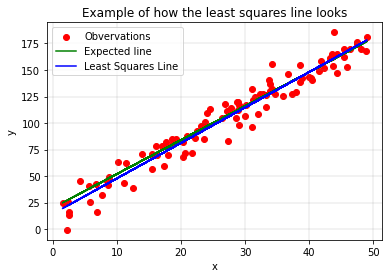

In [224]:
func = lambda x:3.2 * x + 20
x_values, y_values = make_dummy_data(func=func,  x1=0, x2=50, mu=0, sigma=10,  count=100)
_ = plt.scatter(x_values, y_values, color="red")
least_squares_line =  solve_linear_regression(x_values, y_values)
_ = plt.plot(x_values, func(x_values), color='g')
_ = plt.plot(x_values, least_squares_line(x_values), color='b')
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend([ "Obvervations",  'Expected line', 'Least Squares Line'])
_ = plt.title("Example of how the least squares line looks")

### Closed Solution 

The solution we have given above to the problem of Linear Regression is called a **closed formula** meaning that we can apply an single function and calculate the line. 

We will see another way that we can follow fo solve the least squares which will contain all the steps (albeit simpler) that we will use in many other methods on machine learning. 


### The  four assumptions of applying a linear regression model

| Name      | Description |
| ----------- | ----------- |
| Linearity      | The relationship between X and the mean of Y is linear       |
| Homoscedasticity   | The variance of residual is the same for any value of X |
|Independence |Observations are independent of each other.|
|Normality|For any fixed value of X, Y is normally distributed.|


